# Feature extraction from an image using 2D FFT

This notebook demonstrates the extraction of features oriented at 
a certain angle from a random field using 2D Fast Fourier Transform (FFT). 
The steps include the generation of a random field, creation of a Gaussian 
filter in rotated coordinates, filtering in the frequency domain, and visualization 
of the resultant field.


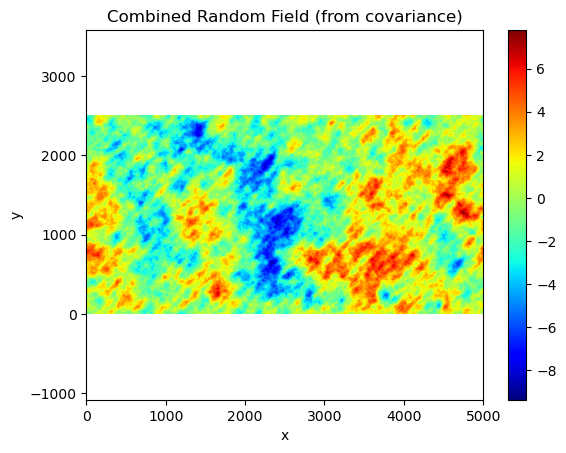

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# Define the physical and grid parameters for the field generation.
Ix, Iy, Iz = 300, 100, 100
nx, ny, nz = 501, 251, 1
dx, dy, dz = 10, 10, 10
sigma = 2

# Grid. Define the spatial grid using numpy and create 3D mesh grids.
x = np.arange(0, dx*nx, dx)
y = np.arange(0, dy*ny, dy)
z = np.arange(0, dz*nz, dz)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Random field generation. 
m = np.random.randn(nx, ny, nz)
fm = np.fft.fftn(m)

cx, cy, cz = (nx-1)*dx/2, (ny-1)*dy/2, (nz-1)*dz/2

# Rotation matrix and filter application
theta = -np.pi/4
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])

# Exponential covariance function describing the randoom field
Nr = np.exp(-np.sqrt((X-cx)**2/Ix**2 + (Y-cy)**2/Ix**2 + (Z-cz)**2/Iz**2))

x1 = R[0,0]*(X-cx) + R[0,1]*(Y-cy)
y1 = R[1,0]*(X-cx) + R[1,1]*(Y-cy)

# Combination of two random fields one isotropic and one oriented at 45 deg
Nr = Nr + 0.2*np.exp(-(4*x1**2/Ix**2 + 4*y1**2/Iy**2 + Z**2/Iz**2))

# Fourier transform and filtering
fNr = np.fft.fftn(Nr)
fNr = np.sqrt(fNr)
fm_flt = fm * fNr
dv = sigma * np.real(np.fft.ifftn(fm_flt))

# Visualization
v = dv[:,:,0]
plt.imshow(np.transpose(v), cmap='jet', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.axis('equal')
plt.title("Combined Random Field (from covariance)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


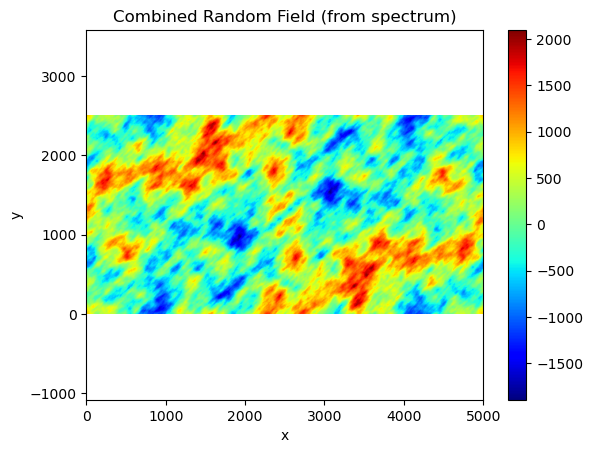

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Ix = 300
Iy = 100
#Iz = 100

nx = 501  
ny = 251
#nz = 1  

dx = 10
dy = 10
#dz = 10

sigma = 2

# Grid
x = np.arange(0, dx*nx, dx)
y = np.arange(0, dy*ny, dy)
#z = np.arange(0, dz*nz, dz)

X, Y = np.meshgrid(x, y, indexing='ij')

# Random field generation
m = np.random.randn(nx, ny)
fm = np.fft.fftn(m)

# Nyquist wavenumbers and wavenumber intervals
knx = 1/2/dx; kny= 1/2/dy; 
dkx = 1/dx/nx; dky=1/dy/ny; 

# Wavenumber vectors and circular wavenumbers
ksx = np.arange(-knx, knx, dkx) * 2*np.pi
ksy = np.arange(-kny, kny, dky) * 2*np.pi
#ksz = np.arange(-knz, knz, dkz) * 2*np.pi

theta = -np.pi/4  

# 2D rotation matrix
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Initialize ff array
ff = np.zeros((nx, ny))

ksx1=0*ksx
ksy1=0*ksy
# Loop through each element and apply rotation and transformation
for ix in range(nx):
    for iy in range(ny):
        #for iz in range(nz):
            
            ksx1[ix] = R[0,0]*ksx[ix] + R[0,1]*ksy[iy]
            ksy1[iy] = R[1,0]*ksx[ix] + R[1,1]*ksy[iy]
            
            ff[ix, iy] = sigma *Ix*Ix/np.pi**2/(1+Ix*Ix*ksx1[ix]**2+Ix*Ix*ksy1[iy]**2)**2 + \
            0.1*sigma/4 *Ix*Ix/np.pi**2/(1+Ix*Ix/4*ksx1[ix]**2+Iy*Iy/4*ksy1[iy]**2)**2

# Filtering and inverse Fourier transform
fm_flt = np.fft.fftn(fm) * np.sqrt(np.fft.ifftshift(ff))
dv = sigma * np.real(np.fft.ifft2(fm_flt))

# Plotting
#plt.imshow(dv)
plt.imshow(np.transpose(dv), cmap='jet', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.axis('equal')
plt.title("Combined Random Field (from spectrum)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

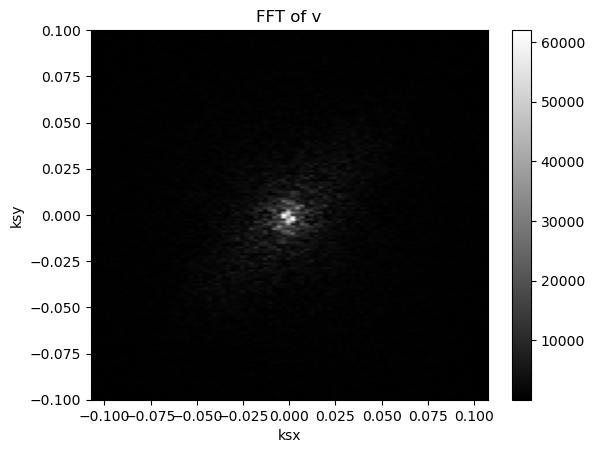

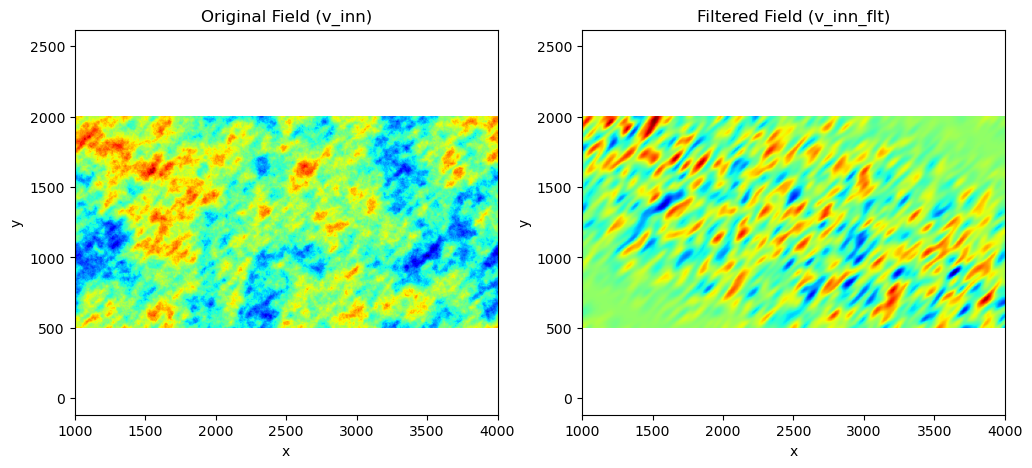

In [32]:


# Anisotropic Gaussian Filter
KX, KY = np.meshgrid(ksx[0:nx], ksy, indexing='ij')  # Generate a mesh grid
KX1 = R[0, 0] * KX + R[0, 1] * KY  # Apply rotation matrix
KY1 = R[1, 0] * KX + R[1, 1] * KY

ax = 0.03  # Define filter parameters
ay = 3*ax
FLT = np.exp(-(KX1**2/ax**2 + KY1**2/ay**2))  # Create Gaussian filter

Sv = np.fft.fft2(v)  # Fourier transform of v

# Visualization of the Fourier transform of v
plt.figure()
plt.imshow(np.abs(np.fft.fftshift(Sv)), cmap='gray', extent=[ksx.min(), ksx.max(), ksy.min(), ksy.max()])
plt.axis('equal')
plt.axis([-0.1, 0.1, -0.1, 0.1])
plt.title("FFT of v")
plt.xlabel("ksx")
plt.ylabel("ksy")
plt.colorbar()
plt.show()

# Apply filter, perform inverse FFT, and extract the inner subdomain
v_flt = np.real(np.fft.ifft2(np.fft.ifftshift(FLT * Sv)))
v_inn_flt = v_flt[dx_inn:dx_inn+nx_inn, dy_inn:dy_inn+ny_inn]

# Visualization of the filter and the filtered random field
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(np.transpose(v), cmap='jet', origin='lower', extent=[x[dx_inn], x[dx_inn + nx_inn-1], y[dy_inn], y[dy_inn + ny_inn-1]])
axs[0].axis('equal')
axs[0].set_title("Original Field (v_inn)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].imshow(np.transpose(v_inn_flt), cmap='jet', origin='lower', extent=[x[dx_inn], x[dx_inn + nx_inn-1], y[dy_inn], y[dy_inn + ny_inn-1]])
axs[1].axis('equal')
axs[1].set_title("Filtered Field (v_inn_flt)")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()


### Aeolian Activity on Mars
Wind can transport particles over large distances on Mars, leading to the formation of new landforms, dunes and ripples. These processes and their effects on the surface must be taken into account in using impact crater statistics to derive chronologies on Mars. Mapping the locations, relative ages, and orientations of aeolian features can provide insight into Martian weather, climate, and climate history. 

The large martian ripples morphologically similar to terrestrial fluid-drag ripples. If the large martian ripples form as wind-drag ripples, then theory developed for current ripples should predict their scale once adjusted for martian conditions. Experiments have led to scaling relations for current ripples. The analysis of the data indicates that the dimensionless quantities related to the geometry of ripples are functions of two dimensionless variables. One of them must be a combination reflecting the intensity of sediment‐transporting flow, the other must be an arrangement of parameters characterizing the physical nature of the liquid and solid phases involved. According to one of the existing scaling relations, the wavelenth of ripples is inversely proportional to the density of the medium (atmosphere) in which sand particles are transported. This relation can be potentially used as a paleoclimate indicator.

$\textbf{Exercise:}$ Determine orientation and dominant wavelength of the martian ripples using a HiRISE (High Resolution Imaging Science Experiment) image below. Assume that the size or the image is 400 meter wide. Determine the density of the atmosphere assiming the relation $1/\rho_a = 126\lambda − 1.2$ (Lorenz et al. 2014 https://doi.org/10.1016/j.icarus.2013.10.026); $\lambda = 2\pi /k$



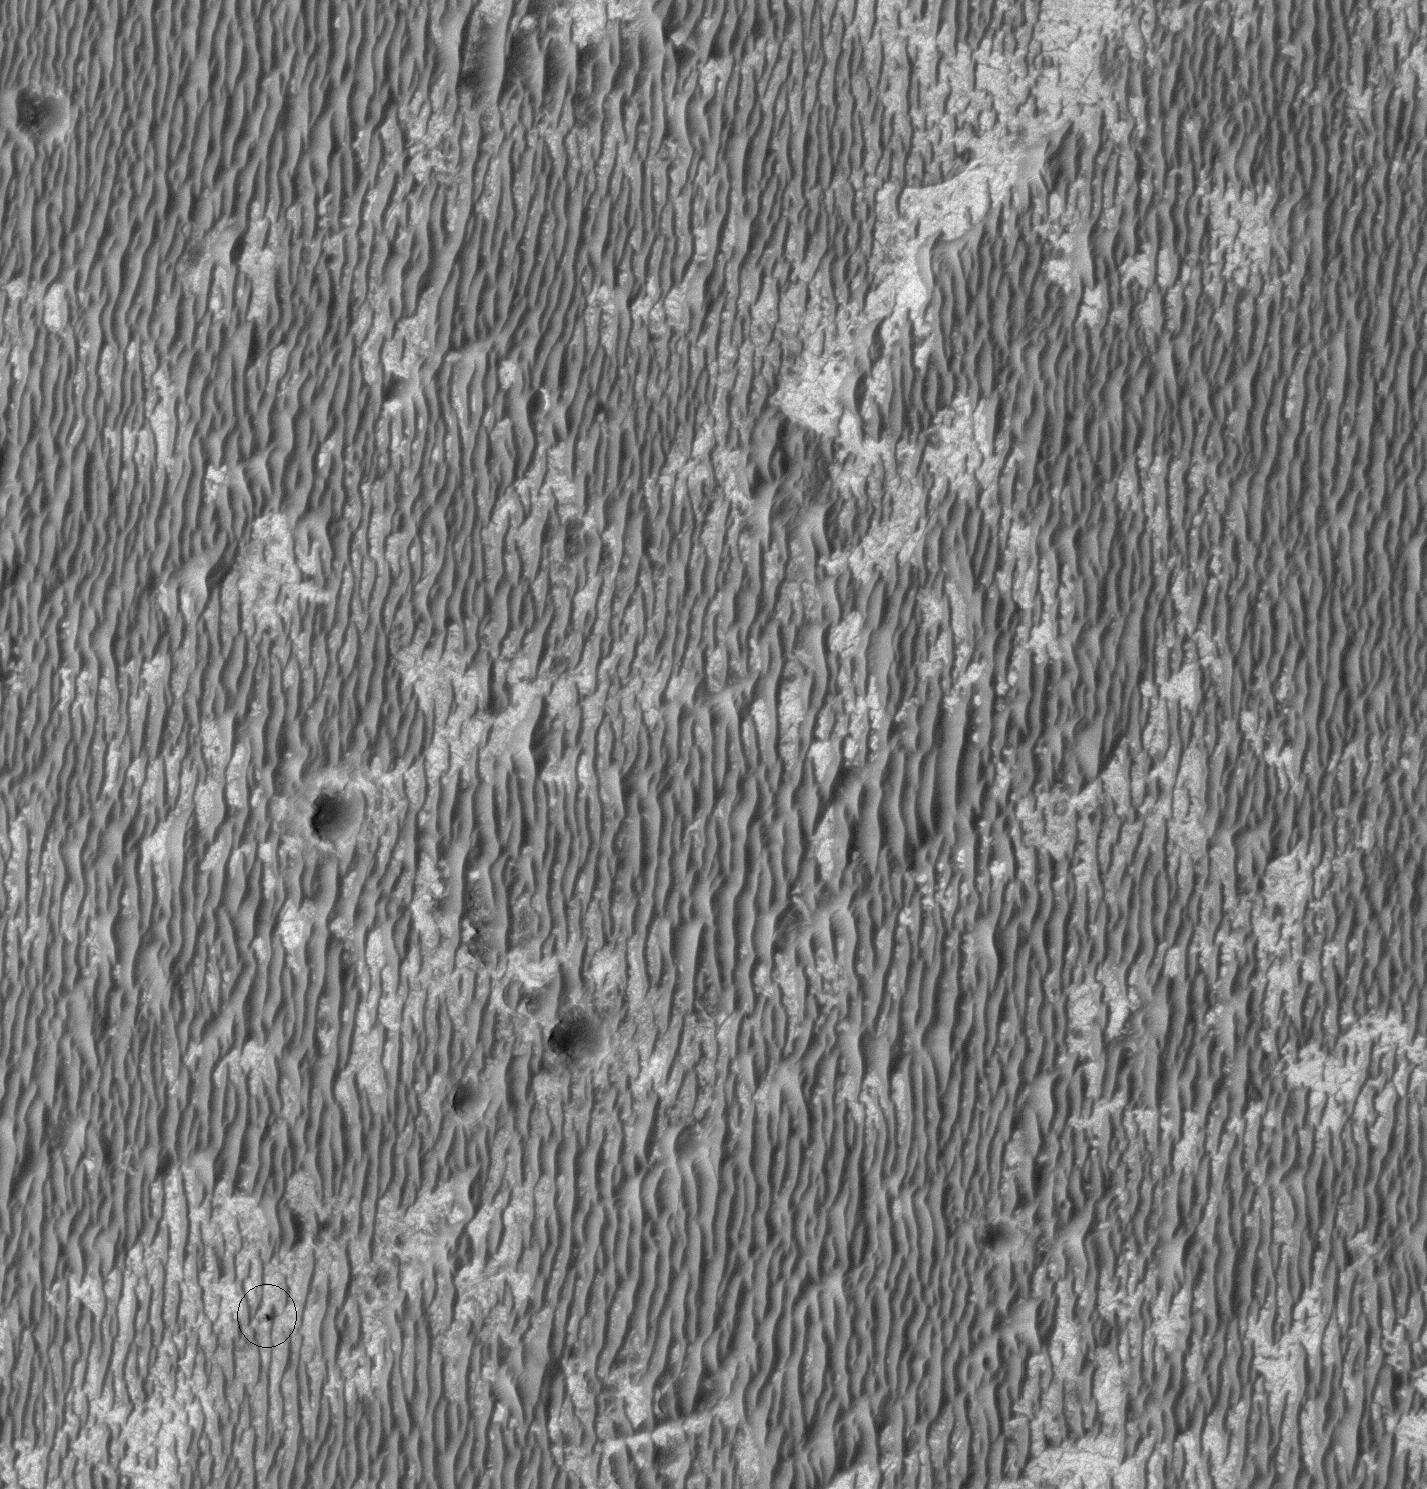

In [4]:
import IPython
url = 'https://www.uahirise.org/images/2009/details/cut/ESP_011765_1780_cut.jpg'
IPython.display.Image(url, width = 600)